## //TODO: Get Y Labels
#### You should probably do this in API.py, so that there can be a different method you call from this cell which chooses tickers, calls getSamples to retrieve the requested X data, selects the samples we want from the X data, and then calculates Y using the <date> in X

In [486]:
import os
import requests
import numpy as np
import pandas as pd
import imp

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

import statsmodels.tsa.api as tsa
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from api_keys import fmp_api_key as api_key
# from API import API
import API
imp.reload(API)
from API import API


api = API(api_key, period='quarter', limit=None)
tickers = api.getRandTickers(50)
# tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']

X = api.getSamplesFromTickers(tickers, samplesPerTicker=100, maxTickers=50)
Y = api.getYFromDF(X)


Making API call request...

Getting X data...
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Ticker didn't have enough data.
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have

Date 2006-09-30 not found for IIIN
Date 2003-12-27 not found for IIIN
Date 2016-07-02 not found for IIIN
Date 2004-10-02 not found for IIIN
Date 2001-12-29 not found for IIIN
Date found for IIIN
Date 1996-06-30 not found for IIIN
Date 2004-03-27 not found for IIIN
Date 2001-09-29 not found for IIIN
Date 2015-03-28 not found for IIIN
Date 2009-03-28 not found for IIIN
Date found for IIIN
Date 2018-09-29 not found for IIIN
Date 2005-10-01 not found for IIIN
Date 2008-06-28 not found for IIIN
Date 2016-01-02 not found for IIIN
Date 2003-09-27 not found for IIIN
Date 2012-06-30 not found for IIIN
Date 2011-01-01 not found for IIIN
Date 2000-07-01 not found for IIIN
Date 1994-09-30 not found for IIIN
Date 2003-06-28 not found for IIIN
Date 2002-09-28 not found for IIIN
Date 2008-12-27 not found for IIIN
Date 2018-03-31 not found for IIIN
Date 2015-06-27 not found for IIIN
Date 2017-12-30 not found for IIIN
Date 2007-03-31 not found for IIIN
Date 2019-06-29 not found for IIIN
Date 1995-09-30

In [489]:
print(api.getNumApiCalls())

113


## Format X and Y Data

In [490]:
print(tickers)

baselinePercentage = .06
Y['baselinePercentage'] = Y.apply(lambda row: baselinePercentage, axis=1)

merged = pd.merge(X, Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()

['GOL', '2013.HK', '6808.HK', 'IBST.L', 'APT.AX', 'XMHQ', 'NFAZ.ME', 'VICE', 'FFEB', '4I1.DE', '2341.HK', 'SX.PA', 'KAU.AX', 'DKE.L', 'SQEW', 'ACMR', 'PEXIP.OL', 'TSCO.L', '1588.HK', 'VASO', 'UN01.DE', 'TRKAW', 'ACTV', 'MTO.AX', 'FMIJX', 'EBIXFOREX.NS', 'FAII', 'CMI', '0883.HK', 'FPH.DE', '0347.HK', 'KWT', 'MKEA.PA', 'QXTR', 'MSC', 'AHL-PE', 'IIIN', '0098.HK', 'RCMT', 'ECO.TO', 'SPXV', 'BMI', 'ENDURANCE.NS', 'IGCF.TO', 'LBE.L', 'CY5.AX', '0QC9.L', 'WLN.PA', 'SOON.SW', 'CTHRX']


In [491]:
X = merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage', 'baselinePercentage'], axis=1)
Y = merged[['percentage']]
Y_baseline = merged[['baselinePercentage']]

In [492]:
# display(merge)
display(X.head())
print(X.columns)
print(X.shape)
display(Y.head())
print(Y.shape)
display(Y_baseline.head())
print(Y_baseline.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,1.561573,0.713524,0.273804,0.050997,0.017653,0.065529,0.031279,2.710353,2.290971,1.439768,...,0.045710,0.035373,-0.007239,0.034250,-0.027112,0.039474,0.172749,0.187500,1.422922e+09,1.832822e+09
1,2.057155,1.284539,0.227353,0.072059,0.030626,0.071561,0.038377,1.271137,2.415156,2.680112,...,0.296004,0.536779,0.143545,0.483146,1.330097,0.666667,1.842105,1.829250,9.112382e+09,8.856382e+09
2,1.483928,0.668582,0.267697,0.057801,0.021151,0.082647,0.040832,2.897805,2.531406,1.350206,...,0.147288,0.196867,0.031562,0.099059,0.431343,0.772595,1.335227,1.434783,1.476316e+09,1.826116e+09
3,1.374485,0.636250,0.269649,0.057993,0.017883,0.077154,0.040609,3.303736,3.133569,1.592190,...,-0.047660,-0.044885,0.002152,-0.017996,-0.136598,-0.177458,-0.214286,-0.258065,1.669252e+09,2.025252e+09
4,1.620853,0.777251,0.231559,0.058371,0.016999,0.045007,0.033579,1.610408,1.615704,1.473721,...,0.133396,0.168285,0.023654,0.125000,0.177570,0.318841,0.185185,0.188245,2.297531e+09,2.812531e+09


Index(['currentRatio', 'quickRatio', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'debtEquityRatio', 'priceToBookRatio',
       'priceToSalesRatio', 'priceEarningsRatio', 'priceEarningsToGrowthRatio',
       'priceToOperatingCashFlowsRatio', 'growthRevenue',
       'growthCostOfRevenue', 'growthGrossProfit', 'growthGrossProfitRatio',
       'growthOperatingExpenses', 'growthEBITDA', 'growthOperatingIncome',
       'growthNetIncome', 'growthEPS', 'marketCapitalization',
       'enterpriseValue'],
      dtype='object')
(106, 24)


,percentage
0,-0.035222
1,1.398822
2,0.020588
3,0.027379
4,-0.398942


(106, 1)


,baselinePercentage
0,0.06
1,0.06
2,0.06
3,0.06
4,0.06


(106, 1)


## Plot Features to Examine Distributions

<ipython-input-493-82ac20f67b5e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


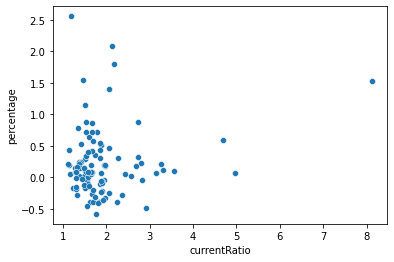

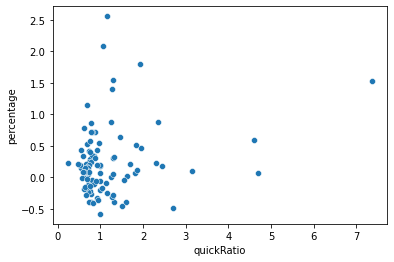

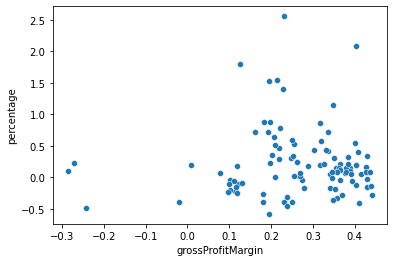

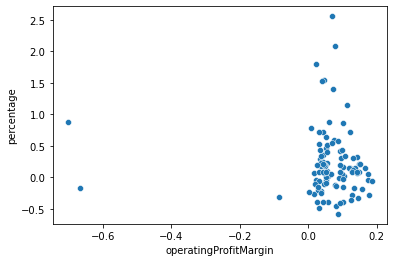

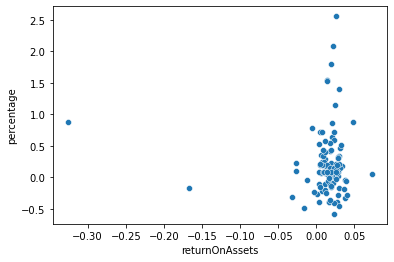

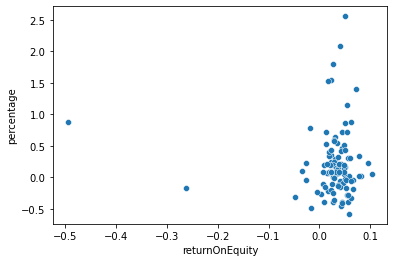

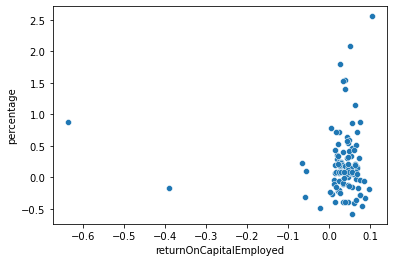

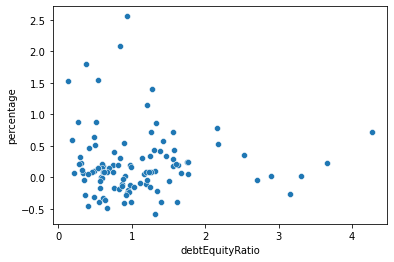

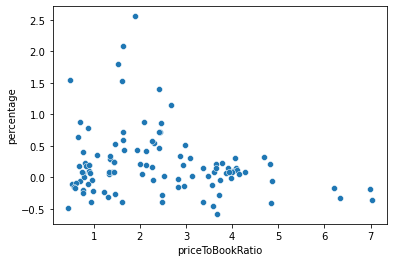

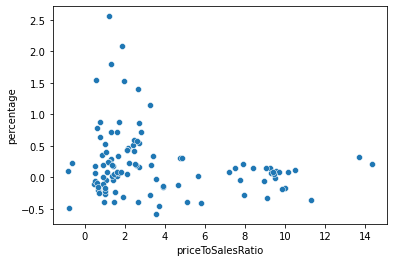

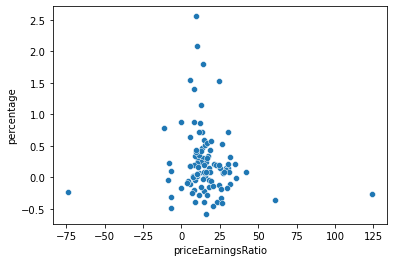

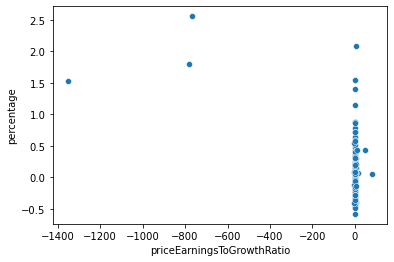

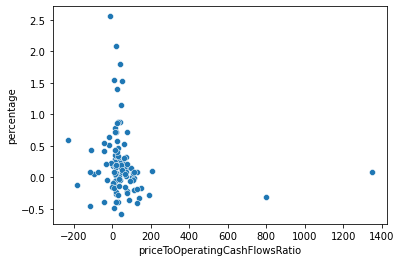

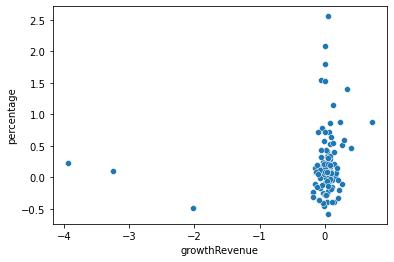

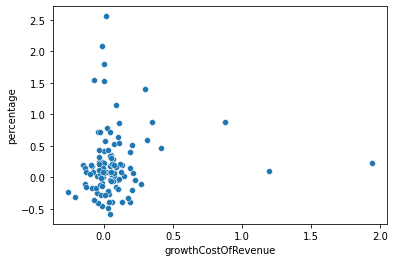

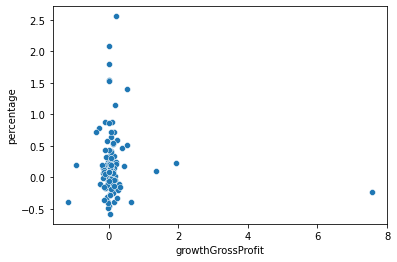

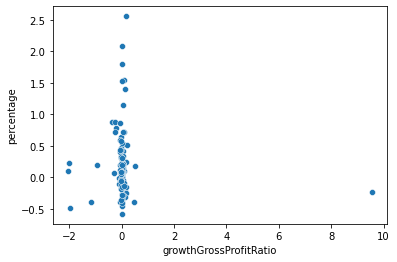

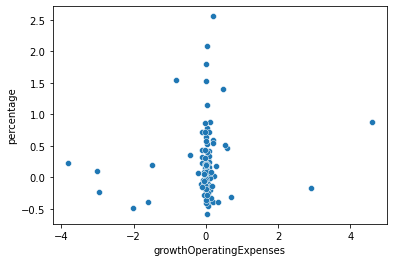

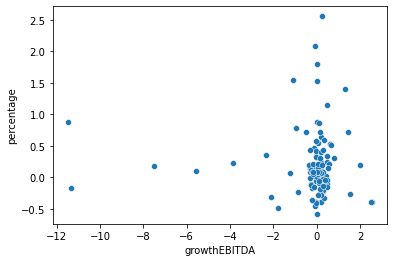

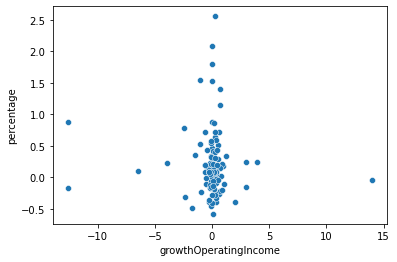

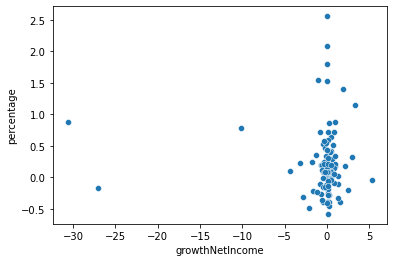

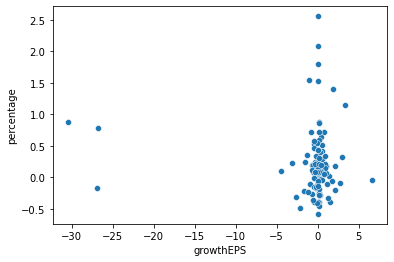

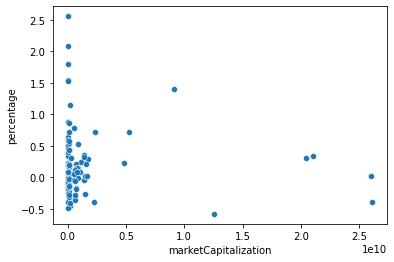

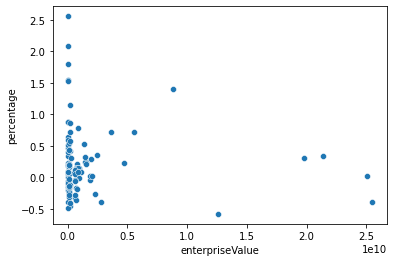

In [493]:
# plt.figure()
for colName in X:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

## Scaling/ Normalization

In [494]:
# min_max_scaler = MinMaxScaler((-1, 1))
# df[percentages] = min_max_scaler.fit_transform(df[percentages])  # No need, because percentages are already on a good scale
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), columns = X.columns)
display(X_scaled.head())



,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,-0.385445,-0.450438,0.036322,-0.091331,0.122074,0.613306,0.027597,2.217209,-0.056906,-0.615399,...,-0.114260,-0.126571,-0.030835,0.086676,0.132571,0.051852,0.169318,0.176311,-0.030120,0.045622
1,0.174414,0.162905,-0.291952,0.093872,0.444278,0.708420,0.114314,0.262545,0.025919,-0.256614,...,0.875649,0.508721,0.119290,0.624671,0.830292,0.306707,0.566125,0.515494,1.623001,1.583146
2,-0.473160,-0.498713,-0.006833,-0.031496,0.208946,0.883225,0.144305,2.471797,0.103452,-0.641306,...,0.287480,0.078045,0.007796,0.164349,0.368256,0.349750,0.445640,0.433998,-0.018641,0.044154
3,-0.596798,-0.533441,0.006961,-0.029810,0.127789,0.796608,0.141581,3.023110,0.505066,-0.571309,...,-0.483535,-0.228260,-0.021485,0.024060,0.076286,-0.036296,0.077320,0.084257,0.022838,0.087747
4,-0.318476,-0.381988,-0.262229,-0.026490,0.105831,0.289725,0.055699,0.723324,-0.507276,-0.605577,...,0.232539,0.041831,-0.000078,0.195439,0.237795,0.165371,0.172274,0.176465,0.157908,0.260089


## Reduce Dimensionality with PCA

In [495]:
pca = PCA(n_components='mle')
X_pc = pca.fit_transform(X_scaled)
# print(pca.components_)
# print(pca.explained_variance_)
display(X_pc.shape)

print("components = " + str(pca.n_components_))

(106, 23)

components = 23


## Examine Distribution on 1st Principle Component

In [496]:
# plt.scatter(X_pc[:,0], Y)
print(X_pc[:,0].shape)
print(Y.shape)
print(Y)

(106,)
(106, 1)
     percentage
0     -0.035222
1      1.398822
2      0.020588
3      0.027379
4     -0.398942
..          ...
102    0.080925
103    0.046265
104   -0.144599
105    0.196203
106    0.087840

[106 rows x 1 columns]


## Transform Data to Polynomial Features, Train Models, and Plot Error

In [497]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def trainAndGetResults(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_test': [], 'mse': [], 'rmse': []}
    for i in range(1, 5):
        if not baseline:
            print("X Shape = ")
            print(X.shape)
            poly = PolynomialFeatures(degree=i)
            poly_features = poly.fit_transform(X)
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            clf = LinearRegression()
            print("Poly Shape = ")
            print(poly_features.shape)
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['rmse'].append(rmse)
    return results

trueBaseResults = trainAndGetResults(X)
baselineBaseResults = trainAndGetResults(X, baseline=True)
truePcResults = trainAndGetResults(X_pc)
baselinePcResults = trainAndGetResults(X_pc, baseline=True)

X Shape = 
(106, 24)
Poly Shape = 
(106, 25)
X Shape = 
(106, 24)
Poly Shape = 
(106, 325)
X Shape = 
(106, 24)
Poly Shape = 
(106, 2925)
X Shape = 
(106, 24)
Poly Shape = 
(106, 20475)
X Shape = 
(106, 23)
Poly Shape = 
(106, 24)
X Shape = 
(106, 23)
Poly Shape = 
(106, 300)
X Shape = 
(106, 23)
Poly Shape = 
(106, 2600)
X Shape = 
(106, 23)
Poly Shape = 
(106, 17550)


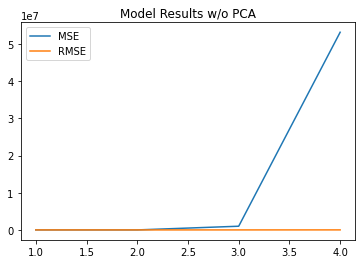

MSEs: [1.4741272303072532, 844.5562967018861, 994389.9883148215, 53211694.524287894]
RMSEs: [1.214136413384943, 29.061250776624984, 997.1910490547042, 7294.6346395339015]

1's top 3 weights were [3.28896425 2.54003476 1.00242742]
at [6 4 3]
2's top 3 weights were [4.40532422e-07 3.50268314e-07 2.84891720e-07]
at [114 152 295]
3's top 3 weights were [4.23230416e-17 4.16846345e-17 3.46426546e-17]
at [2559 2840 2866]
4's top 3 weights were [4.01271586e-28 3.31924667e-28 2.93815397e-28]
at [18091 20401 20402]


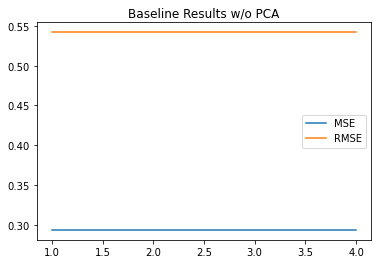

MSEs: [0.2937304810515872, 0.2937304810515872, 0.2937304810515872, 0.2937304810515872]
RMSEs: [0.5419690775787741, 0.5419690775787741, 0.5419690775787741, 0.5419690775787741]



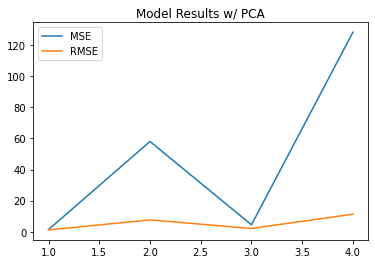

MSEs: [1.4220358490780565, 58.02011977818925, 4.485081080447586, 128.2409221968719]
RMSEs: [1.1924914461236427, 7.61709391948066, 2.1178010011442496, 11.32435085101446]

1's top 3 weights were [0.86771284 0.48261707 0.2627808 ]
at [22 19  5]
2's top 3 weights were [0.885316   0.87828093 0.64799924]
at [175 181 187]
3's top 3 weights were [0.16607118 0.15003522 0.13306687]
at [313 181  40]
4's top 3 weights were [0.08830768 0.08102267 0.07336293]
at [  2 181 180]


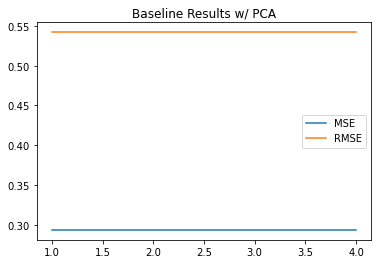

MSEs: [0.2937304810515872, 0.2937304810515872, 0.2937304810515872, 0.2937304810515872]
RMSEs: [0.5419690775787741, 0.5419690775787741, 0.5419690775787741, 0.5419690775787741]



In [498]:
def plotResults(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()
    for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))

plotResults(trueBaseResults, "Model Results w/o PCA")
plotResults(baselineBaseResults, "Baseline Results w/o PCA")
plotResults(truePcResults, "Model Results w/ PCA")
plotResults(baselinePcResults,"Baseline Results w/ PCA")


## Train Neural Net Model

In [499]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetRegressionModel as NNRegModel

trueBaseResultsNN = NNRegModel.trainAndGetResults(X, Y, Y_baseline)
baselineBaseResultsNN = NNRegModel.trainAndGetResults(X, Y, Y_baseline, baseline=True)
truePcResultsNN = NNRegModel.trainAndGetResults(X_pc, Y, Y_baseline)
baselinePcResultsNN = NNRegModel.trainAndGetResults(X_pc, Y, Y_baseline, baseline=True)

X Shape = 
(106, 24)
X Shape = 
(106, 23)


In [500]:
import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetClassificationModel as NNClfModel

Y_clf = NNClfModel.getYClassificationFromMerged(merged)
Y_clf_baseline = NNClfModel.getYBaselineClassificationFromMerged(merged)

# print(merged)

trueBaseResultsNNClf = NNClfModel.trainAndGetResults(X, Y_clf, Y_clf_baseline)
baselineBaseResultsNNClf = NNClfModel.trainAndGetResults(X, Y_clf, Y_clf_baseline, baseline=True)
truePcResultsNNClf = NNClfModel.trainAndGetResults(X_pc, Y_clf, Y_clf_baseline)
baselinePcResultsNNClf = NNClfModel.trainAndGetResults(X_pc, Y_clf, Y_clf_baseline, baseline=True)

X Shape = 
(106, 24)
{'alpha': 0.1, 'epsilon': 1e-08, 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.05}
X Shape = 
(106, 23)
{'alpha': 0.01, 'epsilon': 1e-08, 'hidden_layer_sizes': (20, 5), 'learning_rate_init': 0.05}


## Plot Neural Net Model

In [501]:
def plotResultsNN(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()

NNRegModel.plotResults(trueBaseResultsNN, "NN Reg Model Results w/o PCA")
NNRegModel.plotResults(baselineBaseResultsNN, "Baseline Results w/o PCA")
NNRegModel.plotResults(truePcResultsNN, "NN Reg Model Results w/ PCA")
NNRegModel.plotResults(baselinePcResultsNN,"Baseline Results w/ PCA")

NN Reg Model Results w/o PCA
MSEs: [22832237057.2197]
RMSEs: [151103.39856277124]

Baseline Results w/o PCA
MSEs: [0.2937304810515872]
RMSEs: [0.5419690775787741]

NN Reg Model Results w/ PCA
MSEs: [0.19204316554054385]
RMSEs: [0.43822729894490126]

Baseline Results w/ PCA
MSEs: [0.2937304810515872]
RMSEs: [0.5419690775787741]



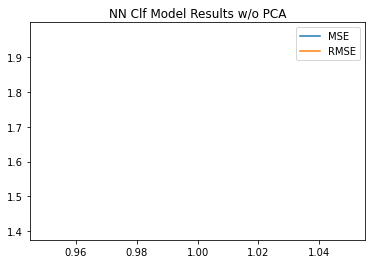

NN Clf Model Results w/o PCA
MSEs: [1.9714285714285715]
RMSEs: [1.4040757000349275]



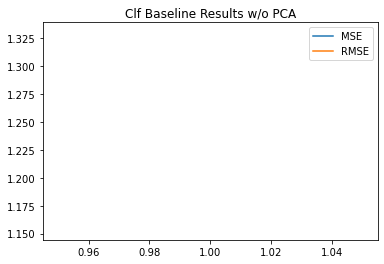

Clf Baseline Results w/o PCA
MSEs: [1.330188679245283]
RMSEs: [1.153338059393378]



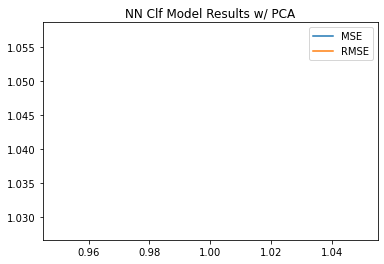

NN Clf Model Results w/ PCA
MSEs: [1.0571428571428572]
RMSEs: [1.0281745265969475]



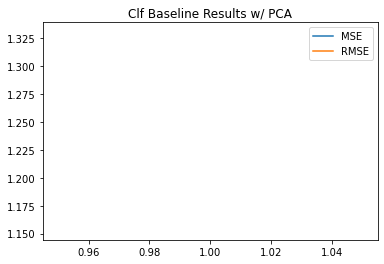

Clf Baseline Results w/ PCA
MSEs: [1.330188679245283]
RMSEs: [1.153338059393378]



In [502]:
# plot classification model results
NNClfModel.plotResults(trueBaseResultsNNClf, "NN Clf Model Results w/o PCA")
NNClfModel.plotResults(baselineBaseResultsNNClf, "Clf Baseline Results w/o PCA")
NNClfModel.plotResults(truePcResultsNNClf, "NN Clf Model Results w/ PCA")
NNClfModel.plotResults(baselinePcResultsNNClf,"Clf Baseline Results w/ PCA")

## Real-World Results

In [503]:
# Collect data from 10 different stocks
final_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']
#- final_pca = PCA(n_components=21)
# final_pca = PCA(n_components='mle')
print("components = " + str(pca.n_components_))
final_pca = PCA(n_components=pca.n_components_)
final_poly = PolynomialFeatures(degree=1)

spy_X = api.getSamplesFromTickers(final_tickers, samplesPerTicker=50, maxTickers=10)
spy_Y = api.getYFromDF(spy_X)

components = 23

Getting X data...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...

Getting Y data...
Making API call request...
Date 1995-03-31 not found for AAPL
Date 1990-06-30 not found for AAPL
Date 2016-06-25 not found for AAPL
Date 2001-12-29 not found for AAPL
Date 1997-03-28 not found for AAPL
Date 1989-12-31 not found for AA

Date 2007-09-30 not found for MSFT
Date 2000-12-31 not found for MSFT
Date 1994-09-30 not found for MSFT
Date 2017-12-31 not found for MSFT
Date found for MSFT
Date found for MSFT
Date 2019-03-31 not found for MSFT
Date 2019-06-30 not found for MSFT
Date 2004-12-31 not found for MSFT
Date found for MSFT
Date found for MSFT
Date 2000-06-30 not found for MSFT
Date 2016-12-31 not found for MSFT
Date found for MSFT
Date 1999-09-30 not found for MSFT
Date 2000-03-31 not found for MSFT
Date 2005-12-31 not found for MSFT
Date found for MSFT
Date 2006-06-30 not found for MSFT
Date 1990-09-30 not found for MSFT
Date found for MSFT
Date 2010-12-31 not found for MSFT
Date found for MSFT
Date 1995-03-31 not found for MSFT
Date found for MSFT
Date found for MSFT
Date 2007-06-30 not found for MSFT
Date found for MSFT
Date 2006-09-30 not found for MSFT
Date 2018-06-30 not found for MSFT
Date found for MSFT
Date found for MSFT
Date 1995-12-31 not found for MSFT
Date found for MSFT
Date 2012-09-30 not 

In [504]:
print(api.getNumApiCalls())

143


In [505]:
spy_merged = pd.merge(spy_X, spy_Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()
spy_X = spy_merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage'], axis=1)
spy_Y = spy_merged[['percentage']]

spy_X_scaled = pd.DataFrame(ss.fit_transform(spy_X), columns = spy_X.columns)
spy_X_pc = final_pca.fit_transform(spy_X_scaled)
spy_X_poly = final_poly.fit_transform(spy_X_scaled)
spy_X_pc_poly = final_poly.fit_transform(spy_X_pc)

In [506]:
# get classification test data
spy_Y_clf = NNClfModel.getYClassificationFromMerged(spy_merged)
spy_Y_clf_baseline = NNClfModel.getYBaselineClassificationFromMerged(spy_merged)

# print(spy_merged)
# print(spy_X.shape)
# print(spy_Y.shape)

In [507]:
display(spy_X.head())

print(spy_X.shape)
print(spy_Y.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,2.408181,1.159514,0.425086,0.120382,0.035888,0.070659,0.081439,0.968898,3.150645,3.595607,...,0.001648,0.028171,0.013873,0.053745,-0.008826,-0.044202,-0.025167,-0.018124,7.192293e+09,6.798493e+09
1,2.521323,1.243205,0.476095,0.115561,0.031957,0.062082,0.072770,0.942679,2.759181,3.363595,...,0.289973,0.145018,-0.060306,-0.287359,-9.849858,-3.957207,-4.126177,-4.090608,5.853327e+09,5.302227e+09
2,2.486968,1.256414,0.406252,0.085668,0.024809,0.048508,0.056355,0.955253,2.715416,3.145034,...,0.261380,0.026313,-0.107139,-0.028530,0.084785,0.197414,0.224753,0.240693,6.207983e+09,5.707283e+09
3,1.446898,1.246436,0.819031,0.358906,0.059030,0.118420,0.132473,1.006091,6.886977,15.779557,...,0.140016,0.086348,-0.008519,-0.032399,0.273426,0.289181,-0.020738,0.003301,2.499008e+11,2.395618e+11
4,4.083458,3.837838,0.846213,0.139292,0.014649,0.018631,0.017321,0.271848,3.809437,29.304638,...,-0.398038,-0.005763,0.100217,0.023997,-0.139718,-0.133559,-0.151065,-0.149097,2.688700e+11,2.595220e+11


(98, 24)
(98, 1)


In [508]:
# print(truePcResults['clf'][0])
print(spy_X_poly.shape)
print(spy_X_pc_poly.shape)

(98, 25)
(98, 24)


In [509]:
r1 = trueBaseResults['clf'][0].predict(spy_X_poly)
r2 = truePcResults['clf'][0].predict(spy_X_pc_poly)

r1MSE = mean_squared_error(spy_Y, r1)
r2MSE = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE)
print(r2MSE)
print(baseMSE)

80.61898225394673
0.7722208891498075
0.4757696818652153


In [510]:
# test neural net results for regression model

r1 = trueBaseResultsNN['clf'][0].predict(spy_X_poly)
# r2 = truePcResultsNN['clf'][0].predict(spy_X_pc_poly)
r2 = truePcResultsNN['clf'][-1].predict(spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y, r1)
r2MSE_NN = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)

2.3161286894470745
0.5081017061377485
0.4757696818652153


In [511]:
# test neural net results for classification model

import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetClassificationModel as NNClfModel

# print(spy_Y_clf)
# print(spy_Y_clf_baseline)

r1 = trueBaseResultsNNClf['clf'][0].predict(spy_X_poly)
r2 = truePcResultsNNClf['clf'][-1].predict(spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y_clf, r1)
r2MSE_NN = mean_squared_error(spy_Y_clf, r2)
baseMSE = mean_squared_error(spy_Y_clf, spy_Y_clf_baseline)

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)

1.1428571428571428
1.7959183673469388
1.1428571428571428


In [512]:
# test neural net results for classification model Pt. 2 
# this is just a little experiment to see if we can use a binary classifier to
# predict the price change percentage

import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetClassificationModel as NNClfModel

r1 = NNClfModel.predict(trueBaseResultsNNClf['clf'][0], spy_X_poly)
r2 = NNClfModel.predict(truePcResultsNNClf['clf'][-1], spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y, r1)
r2MSE_NN = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)

0.4757696818652153
0.48954825833277005
0.4757696818652153
